In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import kagglehub
import os
import torch.functional as F
import torch.nn as nn
import seaborn as sns
from torch import optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Dataset_Preparation and Sampling

In [3]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

Using Colab cache for faster access to the 'flowers-recognition' dataset.


In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)
dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)
print("Total images:", len(dataset))
print("Classes:", dataset.classes)

Total images: 4317
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [5]:
from torch.utils.data import random_split
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
print(len(train_data))
print(len(test_data))
print(len(val_data))

3454
432
431


In [6]:
train_dataset = DataLoader(train_data, batch_size=32, shuffle=True)
len(train_dataset)*32

3456

In [7]:
images, labels = next(iter(train_dataset))
print(images.shape)
temp = images.permute(0,2,3,1).reshape(images.size(0), -1)
print(temp.shape)
print(labels)

torch.Size([32, 3, 224, 224])
torch.Size([32, 150528])
tensor([3, 0, 4, 2, 0, 1, 3, 2, 4, 1, 1, 1, 4, 2, 1, 2, 0, 2, 0, 4, 0, 4, 2, 3,
        3, 1, 4, 0, 2, 4, 3, 3])


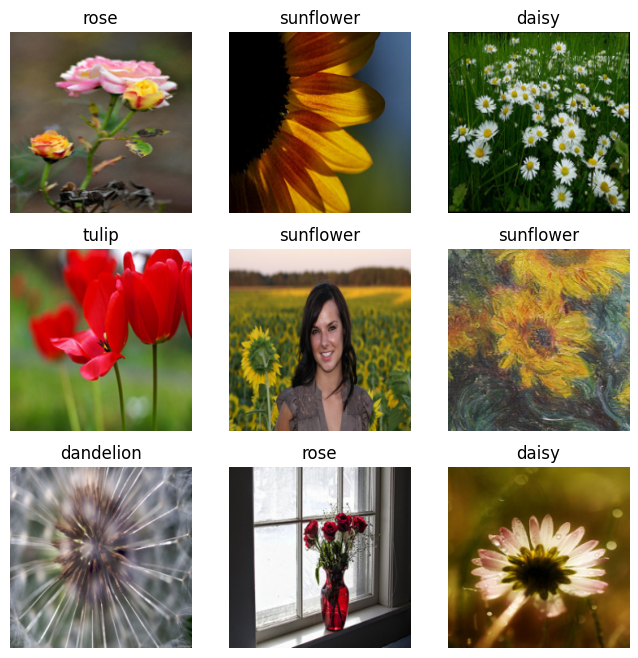

In [8]:
labels_map = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx].permute(1,2,0), labels[sample_idx]   # Inv_normalise to get tensor from a normalised range to [0,1] range
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")    # Permote is used brfore to convert tensor of format [3,224,224] to [224,224,3]
plt.show()

# Training start

The reason we are using `.permute` here to get R,G,B values contiguously for one pixel value.

In [9]:
example = torch.tensor(np.array([[[1,2,3,4],
                                  [2,3,4,5],
                                  [3,4,5,6]],
                                 [[10,20,30,40],
                                  [20,30,40,50],
                                  [30,40,50,60]]]))
example.shape

torch.Size([2, 3, 4])

In [10]:
example.reshape(-1)

tensor([ 1,  2,  3,  4,  2,  3,  4,  5,  3,  4,  5,  6, 10, 20, 30, 40, 20, 30,
        40, 50, 30, 40, 50, 60])

In [11]:
example.permute(1,2,0).reshape(-1)

tensor([ 1, 10,  2, 20,  3, 30,  4, 40,  2, 20,  3, 30,  4, 40,  5, 50,  3, 30,
         4, 40,  5, 50,  6, 60])

In [12]:
# Create a Modal Class that inherits nn.module to make a simple neural network
class model(nn.Module):
  # Input layer (224*3) inputs ---> Hidden layer 1 (16) --> Output Layer (32) --> Softmax(Output)
  def __init__(self, in_feature = 224*224*3, hidden_layer_1 = 16, out_features = 5):
    super().__init__()    # Instantiate our nn.module class
    self.fc1 = nn.Linear(in_feature, hidden_layer_1)
    self.out = nn.Linear(hidden_layer_1, out_features)
  def forward(self, x):
    x = self.fc1(x)
    x = self.out(x)
    return x

In [13]:
torch.manual_seed(41)
Model = model()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr = 0.001)
num_epochs = 10
loss_values=[]

In [ ]:
Model.train()

for epoch in range(num_epochs):
    running_loss = 0.0  # Reset for each epoch

    for images, labels in train_dataset:
        # 1. Forward pass
        outputs = Model(images.permute(0,2,3,1).reshape(images.size(0), -1))
        loss = criterion(outputs, labels)

        # 2. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 3. ACCUMULATE LOSS (Crucial Step)
        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_dataset)
    loss_values.append(avg_loss)

    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

print(loss_values)

Epoch 1, Loss: 9.8903663776539
Epoch 2, Loss: 4.676308136295389
Epoch 3, Loss: 2.676077005487901
Epoch 4, Loss: 2.7386682243258864
Epoch 5, Loss: 2.070470872852537
Epoch 6, Loss: 1.2310291605967063
Epoch 7, Loss: 1.2568584266636107


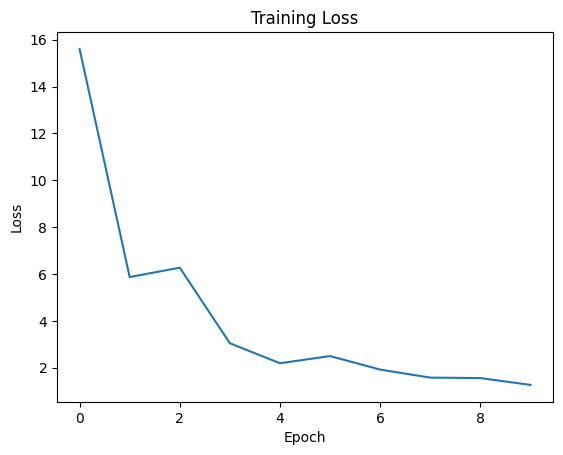

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Test

In [ ]:
test_dataset = DataLoader(test_data, shuffle=True)
images, label = next(iter(test_dataset))
print(images.shape)
print(label)

torch.Size([1, 3, 224, 224])
tensor([2])


In [ ]:
pred_actual_pairs = []
with torch.no_grad():
  for images, label in test_dataset:
    y_eval = Model(images.permute(0,2,3,1).reshape(images.size(0), -1))
    pred_actual_pairs.append({torch.argmax(y_eval), int(label)})
    # print(f'Prediction: {torch.argmax(y_eval)} \t Actual: {int(label)}')

Overall Accuracy: 0.4491
           daisy  dandelion  rose  sunflower  tulip
daisy         13         17    14         12     16
dandelion      9         44    16         16     22
rose           5          6    33          9     35
sunflower      2          4     2         51     12
tulip          2          5    19         15     53
              precision    recall  f1-score   support

       daisy     0.4194    0.1806    0.2524        72
   dandelion     0.5789    0.4112    0.4809       107
        rose     0.3929    0.3750    0.3837        88
   sunflower     0.4951    0.7183    0.5862        71
       tulip     0.3841    0.5638    0.4569        94

    accuracy                         0.4491       432
   macro avg     0.4541    0.4498    0.4320       432
weighted avg     0.4583    0.4491    0.4351       432

daisy       : 0.1806
dandelion   : 0.4112
rose        : 0.3750
sunflower   : 0.7183
tulip       : 0.5638
Macro Precision: 0.4540725904140654
Macro Recall   : 0.44978203104311

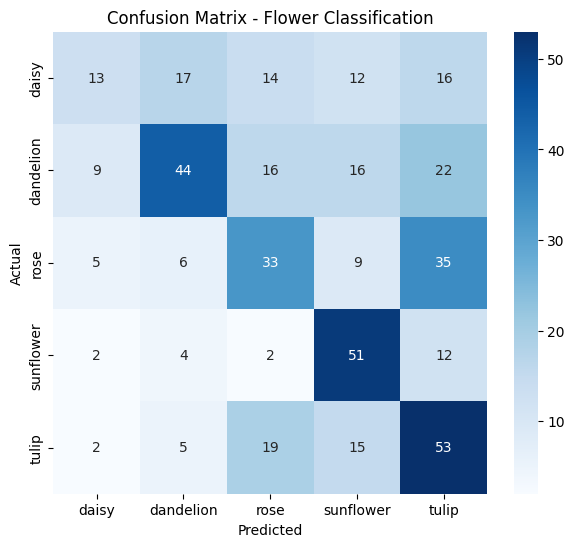

In [ ]:
y_pred = np.array([p for p, a in pred_actual_pairs])
y_true = np.array([a for p, a in pred_actual_pairs])

accuracy = (y_pred == y_true).mean()
print(f"Overall Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=labels_map, columns=labels_map)
print(cm_df)

report = classification_report(
    y_true,
    y_pred,
    target_names=labels_map,
    digits=4
)
print(report)

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"{labels_map[i]:12s}: {acc:.4f}")

print("Macro Precision:", precision_score(y_true, y_pred, average='macro'))
print("Macro Recall   :", recall_score(y_true, y_pred, average='macro'))
print("Macro F1       :", f1_score(y_true, y_pred, average='macro'))
print("Weighted F1    :", f1_score(y_true, y_pred, average='weighted'))

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Flower Classification")
plt.show()